# Exploratory Data Analysis (EDA): Used Cars Market

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [37]:
df = pd.read_csv('../data/processed/olx_cars_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3375 entries, 0 to 3374
Data columns (total 72 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   url                                3375 non-null   object 
 1   title_list                         3375 non-null   object 
 2   color_list                         3274 non-null   object 
 3   description                        3375 non-null   object 
 4   modelo                             3375 non-null   object 
 5   marca                              3375 non-null   object 
 6   tipo_de_veículo                    3053 non-null   object 
 7   combustível                        3304 non-null   object 
 8   câmbio                             3305 non-null   object 
 9   direção                            3255 non-null   object 
 10  cor                                3325 non-null   object 
 11  possui_kit_gnv                     3362 non-null   objec

### The Target Variable Problem (Price)

Our primary goal is to predict `price_clean`. Let's start by examining its distribution. 

If the distribution is skewed (asymmetrical), most standard regression models will perform poorly, as they often assume a normally distributed error.

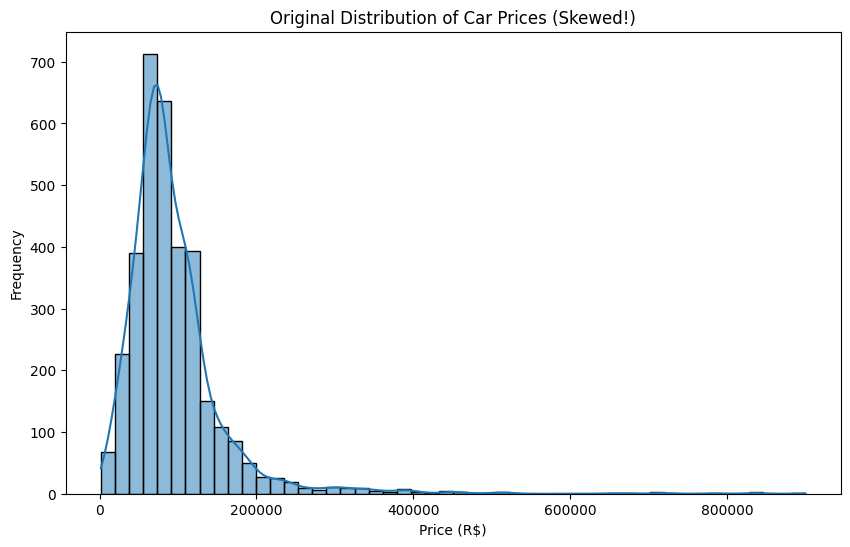

In [38]:
# Plot the original price distribution
plt.figure(figsize=(10, 6))
sns.histplot(x=df['price_clean'], kde=True, bins=50)
plt.title('Original Distribution of Car Prices (Skewed!)')
plt.xlabel('Price (R$)')
plt.ylabel('Frequency')
plt.show()

**Conclusion:** As suspected, the distribution is heavily **right-skewed**. The vast majority of cars are clustered at the low end, with a long tail of expensive luxury vehicles.

**The Solution:** We will not remove this data; these expensive cars are legitimate listings. Instead, we will apply a **logarithmic transformation** to the target variable. This will "pull in" the long tail and make the distribution more normal.

**Feature Engineering:** This is the perfect time to create all our core engineered features: `log_price`, `car_age`, and `km_per_year`.

In [42]:
# --- Feature Engineering (V2 - Corrigida) ---
import numpy as np

# 1. Create log_price (OUR TRUE TARGET)
# We use log1p (which is log(1+x)) to avoid issues if a price were 0.
df['log_price'] = np.log1p(df['price_clean'])

# 2. Create car_age
# We'll use 2025 as the project's base year for consistent calculation
CURRENT_YEAR = 2025 
df['car_age'] = CURRENT_YEAR - df['ano_limpo']

df.loc[df['car_age'] <= 0, 'car_age'] = 0.5

# 3. Create km_per_year
# Fill NaNs in mileage before division
df['quilometragem_clean'] = df['quilometragem_clean'].fillna(0)

df['km_per_year'] = df['quilometragem_clean'] / df['car_age']

# Clean up any potential infinite values
df['km_per_year'] = df['km_per_year'].replace([np.inf, -np.inf], np.nan).fillna(0)


df[['log_price', 'car_age', 'km_per_year']].describe()

,log_price,car_age,km_per_year
count,3375.000000,3375.000000,3375.000000
mean,11.289129,4.765926,31145.375988
std,0.587709,5.538666,27852.221035
min,7.432484,0.500000,0.000000
25%,10.992823,1.000000,11720.726190
50%,11.279744,2.000000,20226.500000
75%,11.627111,7.000000,44603.500000
max,13.710040,43.000000,312014.500000


### The Solution

Now that we've created `log_price`, let's plot its distribution. To make this portfolio-ready and interactive for our GitHub Pages site, we'll use **Plotly**.

In [44]:
# Plot the new, log-transformed target
fig = px.histogram(
    df, 
    height=600,
    x='log_price', 
    title='Distribution of Log-Transformed Price (Our Corrected Target)',
    marginal='box', # This adds a boxplot on top, which is fantastic
    labels={'log_price': 'Price (Log-Transformed)'}
)

# This will display in the notebook and be exported to the final HTML
fig.show()

**Conclusion:** This is *much* better. The distribution is now approximately normal (Gaussian), which is exactly what our models need.

### What Drives the Price?

Now that we have our target (`log_price`) and engineered features, let's see how they relate to each other. A **heatmap** is the
perfect tool for this. 

We'll include our key numeric features and also some of the most important boolean columns (luxury options) to see their impact.

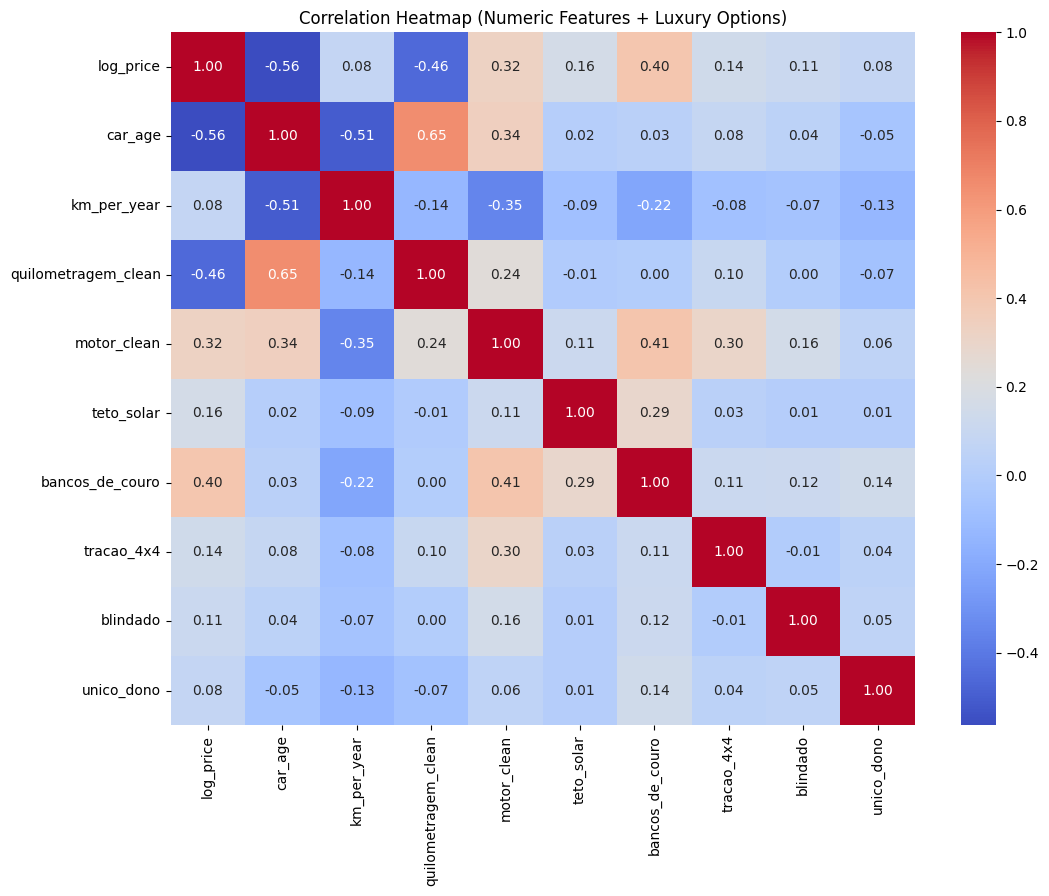

In [45]:
# Select columns for the correlation heatmap
heatmap_cols = [
    # Target
    'log_price',
    
    # Engineered Numerics
    'car_age',
    'km_per_year',
    
    # Raw Numerics
    'quilometragem_clean',
    'motor_clean',
    
    # Boolean Luxury Options
    'teto_solar',
    'bancos_de_couro',
    'tracao_4x4',
    'blindado',
    'unico_dono'
]

# Calculate the correlation matrix
# We drop NaNs just for this plot (e.g., if 'motor_clean' has missing values)
corr_matrix = df[heatmap_cols].dropna().corr()

# Plot the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(
    corr_matrix,
    annot=True,     # Show the correlation values
    cmap='coolwarm',# Use a clear color scheme (blue=negative, red=positive)
    fmt='.2f'       # Format to 2 decimal places
)
plt.title('Correlation Heatmap (Numeric Features + Luxury Options)')
plt.show()

**Conclusion:** The heatmap confirms our real-world logic.
- Strongest Negative: car_age (-0.56). This is our most powerful predictor. The older a car gets, the cheaper it becomes. This is the most intuitive rule in the used car market.

- Strong Negative: quilometragem_clean (-0.46). This is the second strongest signal. More kilometers = more wear = lower price.

- Strongest Positive: bancos_de_couro (Leather Seats) (0.40). This is a massive signal. It's a clear indicator of a higher "trim level" or luxury, which directly impacts price.

- Moderate Positive: motor_clean (Engine Size) (0.32). Makes sense. Bigger engines (e.g., 2.0, 3.0) are in more expensive cars (trucks, SUVs, sports cars) compared to 1.0 city cars.

- Weak Positive: teto_solar, tracao_4x4, blindado (Sunroof, 4x4, Armored) all show a clear positive impact, confirming they are valuable optional features.

- The "Huh?" Insight: km_per_year (0.08) has a very weak linear correlation. This doesn't mean it's a bad feature! It just means its relationship with price isn't a simple straight line. A tree-based model (like Random Forest) will likely still find it very useful for decision splits (e.g., "is km_per_year > 50,000?").

### The Hidden Insight

In [68]:
top_15_brands = df['marca'].value_counts().head(15).index

df_top15 = df[df['marca'].isin(top_15_brands)]

px.box(df_top15, y='marca', x='log_price', height=600, title='Distribution of Log-Transformed Car Prices by Top 15 Brands', category_orders={'marca': top_15_brands.tolist()})

Now for the categorical features. `brand` is an obvious predictor (a BMW is more expensive than a Fiat). 

But what about location (`state_clean`)? Intuitively, one might think SP (São Paulo) and RJ (Rio de Janeiro) are the most expensive markets. Let's check the data.

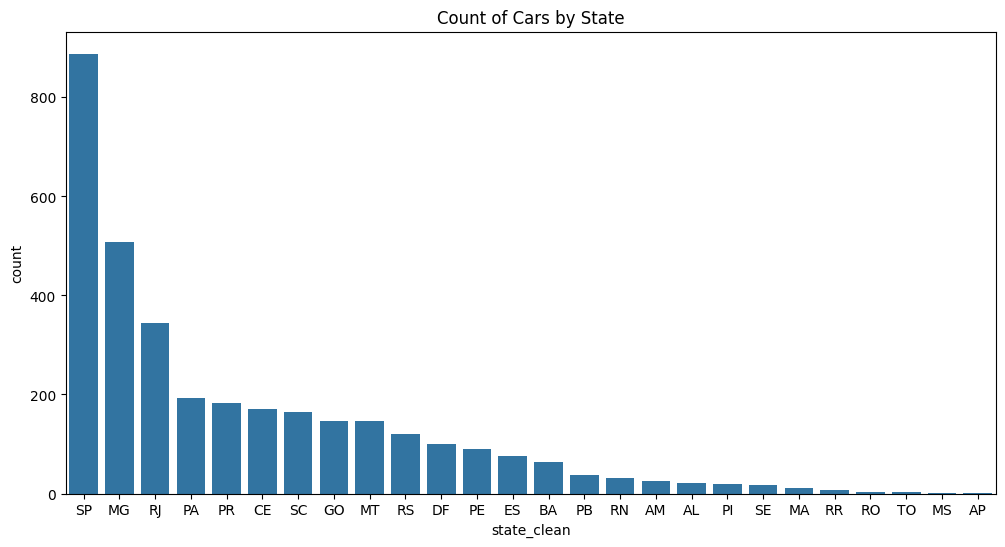

Car counts by State (Top 15):


state_clean
SP    0.263111
MG    0.150222
RJ    0.101926
PA    0.057185
PR    0.054222
CE    0.050370
SC    0.048593
GO    0.043556
MT    0.043259
RS    0.035556
DF    0.029926
PE    0.026667
ES    0.022222
BA    0.018667
PB    0.010963
Name: proportion, dtype: float64

In [72]:
plt.figure(figsize=(12, 6))
sns.countplot(x='state_clean', data=df, order=df['state_clean'].value_counts().index)
plt.title('Count of Cars by State')
plt.show()

print("Car counts by State (Top 15):")
df['state_clean'].value_counts(normalize=True).head(15)

**Whoa.** This is a critical insight. 

Over 50% of our entire dataset comes from just 3 states (SP, MG, RJ). This is a massive **sampling bias**. The "average price in SP" is, by default, the "average price of our entire dataset".

Now let's see the median price, keeping this bias in mind.

In [79]:
# Let's analyze the median price by state, but only for states with
# a significant number of listings (e.g., > 20) to avoid noise.

# 1. Get state counts
state_counts = df['state_clean'].value_counts()

# 2. Filter for states with > 20 listings
relevant_states = state_counts[state_counts > 20].index

# 3. Filter the dataframe and get the median log_price
df_relevant_states = df[df['state_clean'].isin(relevant_states)]
median_prices_by_state = df_relevant_states.groupby('state_clean')['log_price'].median().sort_values(ascending=False)

print("\n--- Median Price (Log) by State (Volume > 20) ---")
print("\nTOP 10 MOST EXPENSIVE STATES:")
print(median_prices_by_state.head(10))
print("\nTOP 10 CHEAPEST STATES:")
print(median_prices_by_state.tail(10))


--- Median Price (Log) by State (Volume > 20) ---

TOP 10 MOST EXPENSIVE STATES:
state_clean
RS    11.602765
ES    11.501875
AL    11.454669
PE    11.439776
AM    11.439290
GO    11.407465
PB    11.360951
PR    11.349241
PA    11.344519
SC    11.337929
Name: log_price, dtype: float64

TOP 10 CHEAPEST STATES:
state_clean
PA    11.344519
SC    11.337929
CE    11.279744
MT    11.269592
BA    11.259336
MG    11.257917
SP    11.238436
DF    11.222587
RJ    11.197481
RN    11.163240
Name: log_price, dtype: float64


**The Key Insight:** Just as the `value_counts` predicted, SP, RJ, and DF (Distrito Federal) are on the **cheapest** list.

**Why?**
* **Hypothesis 1 (Market):** More competition in major markets drives prices down.
* **Hypothesis 2 (Bias):** Our sample size for the "expensive" states (like AL, RS) is so small (22, 120 cars) that it's statistically "noisy" and unreliable. A few expensive trucks in that small sample can skyrocket the median.

**Modeling Decision:** Both hypotheses are likely true. For our V1 model, we cannot trust the states with low counts. In our `feature/builder.py` script, we will group all states with (for example) < 50 listings into a single category: `STATE_OTHER`. This will make our model much more robust.

### EDA Conclusion (End of Week 2)

Our exploratory analysis is complete. Our key findings and action plan are:

1.  **Target:** We **must** use `log_price` as our target variable for modeling.
2.  **Numeric Features:** `car_age` and `km_per_year` are powerful engineered features.
3.  **Categorical Features:** `brand` and `state_clean` are crucial predictors.
4.  **Action Plan:** `state_clean` must be treated for its long-tail (Sampling Bias) by grouping rare states into a `STATE_OTHER` category.

We are ready for Week 3: Moving this Feature Engineering logic into the `feature/` folder and training our V1 Model.